In [1]:
# !pip install keras2onnx  #For older tensorflow (up to 2.3.1)
!pip install tf2onnx  #For newer tensorflow (I tested on 2.4.4)
!pip install onnxruntime
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
Looking in indexes: https://pypi.org/simple

In [2]:
"""
This tutorial covers the following topics...
1. Training a keras model for multiclass classification using the cifar10 dataset.
2. Saving the keras model as .h5
3. Classification using the saved keras .h5 model
4. Converting the keras model to onnx format
5.Classification using the onnx model (and comparison to the keras results)

"""

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

In [3]:
#Let us extract only the 50000 training data available from cifar for this exercise.  
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


print("The size of training dataset is: ", X_train.shape)
print("The size of testing dataset is: ", X_test.shape)
print("The size of training dataset y is: ", y_train.shape)
print("The size of testing dataset y is: ", y_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
The size of training dataset is:  (50000, 32, 32, 3)
The size of testing dataset is:  (10000, 32, 32, 3)
The size of training dataset y is:  (50000, 1)
The size of testing dataset y is:  (10000, 1)


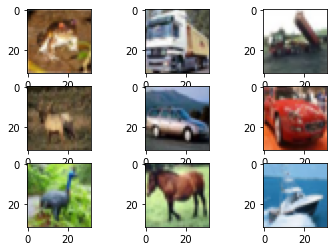

In [4]:
#view few images 
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i])
plt.show()


In [5]:
# prepare and converting data to categorical

X_train = (X_train.astype('float32')) / 255.
X_test = (X_test.astype('float32')) / 255.

# Print a few y_train values to see before and after categorical
print(y_train[0])
print(y_train[1])
print(y_train[10])

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


print(y_train_cat[0])
print(y_train_cat[1])
print(y_train_cat[10])

[6]
[9]
[4]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [6]:
#Define Model with BatchNormalization and Dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [7]:

#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval. 

#Give unique name to save all models as accuracy improves
#filepath="/content/drive/MyDrive/Colab Notebooks/saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.

#Overwrite the model each time accuracy improves. Saves a lot of space. 
#filepath="/content/drive/MyDrive/Colab Notebooks/saved_models/best_model.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss. So we can plot later.
#log_csv = CSVLogger('/content/drive/MyDrive/Colab Notebooks/saved_logs/my_logs.csv', separator=',', append=False)

callbacks_list = [early_stop]

In [9]:
#Fit model....

history = model.fit(X_train, y_train_cat, 
                    epochs=50, batch_size=64, 
                    validation_data=(X_test, y_test_cat), 
                    verbose=1, callbacks=callbacks_list)


_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy = ", (acc * 100.0), "%")

Epoch 1/50
782/782 [==============================] - 12s 15ms/step - loss: 0.7662 - accuracy: 0.7334 - val_loss: 0.7474 - val_accuracy: 0.7385
Epoch 2/50
782/782 [==============================] - 11s 14ms/step - loss: 0.7309 - accuracy: 0.7460 - val_loss: 0.6540 - val_accuracy: 0.7677
Epoch 3/50
782/782 [==============================] - 11s 14ms/step - loss: 0.6889 - accuracy: 0.7610 - val_loss: 0.6742 - val_accuracy: 0.7623
Epoch 4/50
782/782 [==============================] - 11s 14ms/step - loss: 0.6542 - accuracy: 0.7727 - val_loss: 0.6328 - val_accuracy: 0.7797
Epoch 5/50
782/782 [==============================] - 11s 14ms/step - loss: 0.6322 - accuracy: 0.7804 - val_loss: 0.5867 - val_accuracy: 0.7924
Epoch 6/50
782/782 [==============================] - 11s 14ms/step - loss: 0.5948 - accuracy: 0.7934 - val_loss: 0.5710 - val_accuracy: 0.8007
Epoch 7/50
782/782 [==============================] - 11s 14ms/step - loss: 0.5688 - accuracy: 0.8046 - val_loss: 0.5555 - val_accuracy:

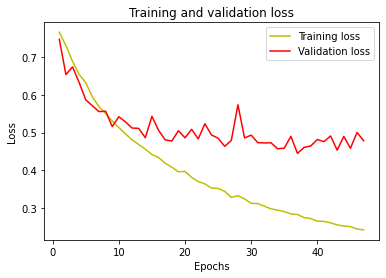

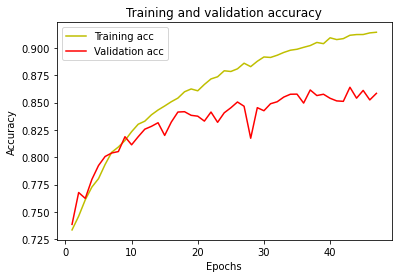

In [12]:
#plot the training and validation accuracy and loss at each epoch
#If validation loss is lower than training loss this could be becuase we are applying
#regularization (Dropout) during training which won't be applied during validation. 
#Also, training loss is measured during each epoch while validation is done after the epoch. 


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
#Save keras model for future use

model.save('cifar_model_50epochs.h5') 


In [17]:
#Load The saved model 
from tensorflow.keras.models import load_model
loaded_keras_model = load_model('cifar_model_50epochs.h5')

1/1 [==============================] - 0s 25ms/step
Original class is: truck
Predicted class is: truck


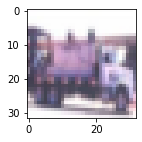

In [27]:
# #Inference using the saved keras model. 
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth= np.argmax(y_test_cat[test_img_number], axis=None)
prediction = loaded_keras_model.predict(test_img_input)
#print(prediction)



predicted_class = np.argmax(prediction, axis=None)

plt.figure(figsize=(2, 2))
plt.imshow(test_img)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
original_label=classes[ground_truth]
prediction_label=classes[predicted_class]

print("Original class is:", original_label)
print("Predicted class is:", prediction_label)

In [28]:
#convert keras model to ONNX
import onnx
import os
#os.environ['TF_KERAS'] = '1'
import tf2onnx #keras2onnx, 

#Load The saved model 
loaded_keras_model = load_model('cifar_model_50epochs.h5')

onnx_model, _ = tf2onnx.convert.from_keras(loaded_keras_model)

onnx.save(onnx_model, 'cifar10_onnx_50epochs.onnx')

1/1 [==============================] - 0s 22ms/step
_________________________________________________
Original class is: cat
Predicted class using ONNX is: cat
Predicted class using Keras is: cat
_________________________________________________
Predicted probabilities for all classes using ONNX is: [[1.8707601e-07 2.8830469e-05 8.1250727e-07 9.9739218e-01 3.9551473e-06
  2.4887407e-03 4.7215635e-06 9.3867538e-06 2.1846188e-06 6.8857044e-05]]
____________________________________
Predicted probabilities for all classes using Keras is: [[1.8707674e-07 2.8830496e-05 8.1251034e-07 9.9739218e-01 3.9551624e-06
  2.4887396e-03 4.7215863e-06 9.3867811e-06 2.1846292e-06 6.8857240e-05]]


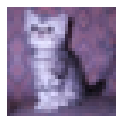

In [40]:
#Inference using ONNX (and keras for comparison)

import onnxruntime

session = onnxruntime.InferenceSession("cifar10_onnx_50epochs.onnx")
session.get_inputs()[0].shape
session.get_inputs()[0].type


input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


test_img_number_onnx = random.randint(0, len(X_test))
test_img_onnx = X_test[test_img_number_onnx]

test_img_input_onnx=np.expand_dims(test_img_onnx, 0)
ground_truth_onnx = np.argmax(y_test_cat[test_img_number_onnx], axis=None)

result = session.run([output_name], {input_name: test_img_input_onnx})
predicted_class_onnx = np.argmax(result, axis=None)

plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(test_img_onnx)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
original_label_onnx=classes[ground_truth_onnx]
prediction_label_onnx=classes[predicted_class_onnx]

#Prediction using keras model
prediction_keras = loaded_keras_model.predict(test_img_input_onnx)
predicted_class_keras = np.argmax(prediction_keras, axis=None)
prediction_label_keras=classes[predicted_class_keras]

print("_________________________________________________")
print("Original class is:", original_label_onnx)
print("Predicted class using ONNX is:", prediction_label_onnx)
print("Predicted class using Keras is:", prediction_label_keras)
print("_________________________________________________")
print("Predicted probabilities for all classes using ONNX is:", result[0])
print("____________________________________")
print("Predicted probabilities for all classes using Keras is:", prediction_keras)